# ScRNA-Seq of human PBMCs

<br>Data from [Freytag, S. et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124389/)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse115189  

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
# Path of data
file = '../../../../../data/raw/immune_cells/pbmcs_human/GSE115189/GSM3169075_filtered_gene_bc_matrices_h5.h5'

# Read data
adata = sc.read_10x_h5(filename=file)

adata.var_names_make_unique()

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [3]:
print(adata.X.shape)
print(adata)

(3372, 58302)
AnnData object with n_obs × n_vars = 3372 × 58302
    var: 'gene_ids'


In [4]:
adata.var.head()

,gene_ids
DDX11L1,ENSG00000223972
WASH7P,ENSG00000227232
MIR6859-1,ENSG00000278267
MIR1302-2HG,ENSG00000243485
MIR1302-2,ENSG00000284332


In [5]:
adata.X = adata.X.toarray()

## Preprocessing

In [6]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    n_counts  log_n_counts  n_genes  log_n_genes  \
AAACCTGAGCGTGTCC-1    5711.0      8.650325     1535     7.336937   
AAACCTGAGTACACCT-1    2755.0      7.921535     1003     6.911747   
AAACCTGAGTGTACGG-1    2705.0      7.903227     1040     6.947937   
AAACCTGCATCACAAC-1    4474.0      8.406261     1308     7.177019   
AAACCTGGTAAATGAC-1    4372.0      8.383204     1433     7.268223   
...                      ...           ...      ...          ...   
TTTGTCACATCGGAAG-1    1083.0      6.988413      523     6.261492   
TTTGTCAGTACTCAAC-1    2997.0      8.005701     1162     7.058758   
TTTGTCAGTAGTACCT-1    2105.0      7.652546      956     6.863803   
TTTGTCAGTGCAACGA-1    4297.0      8.365905     1269     7.146772   
TTTGTCAGTTGAACTC-1    5880.0      8.679482     1730     7.456455   

                    pct_counts_in_top_20_genes   mt_frac  ribo_frac  hem_frac  
AAACCTGAGCGTGTCC-1                    0.271406  0.051305   0.467694  0.000175  
AAACCTGAGTACACCT-1     

In [7]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5,5])

Number of cells before QC filtering: 3372
Number of cells removed by log_n_genes filtering: 148
Number of cells removed by log_n_counts filtering: 35
Number of cells removed by pct_counts_in_top_20_genes filtering: 37
Number of cells removed by mt_frac filtering: 92
Number of cells post QC filtering: 3131
Number of genes before filtering: 58302
Number of genes after filtering so theres min 20 unique cells per gene: 12431


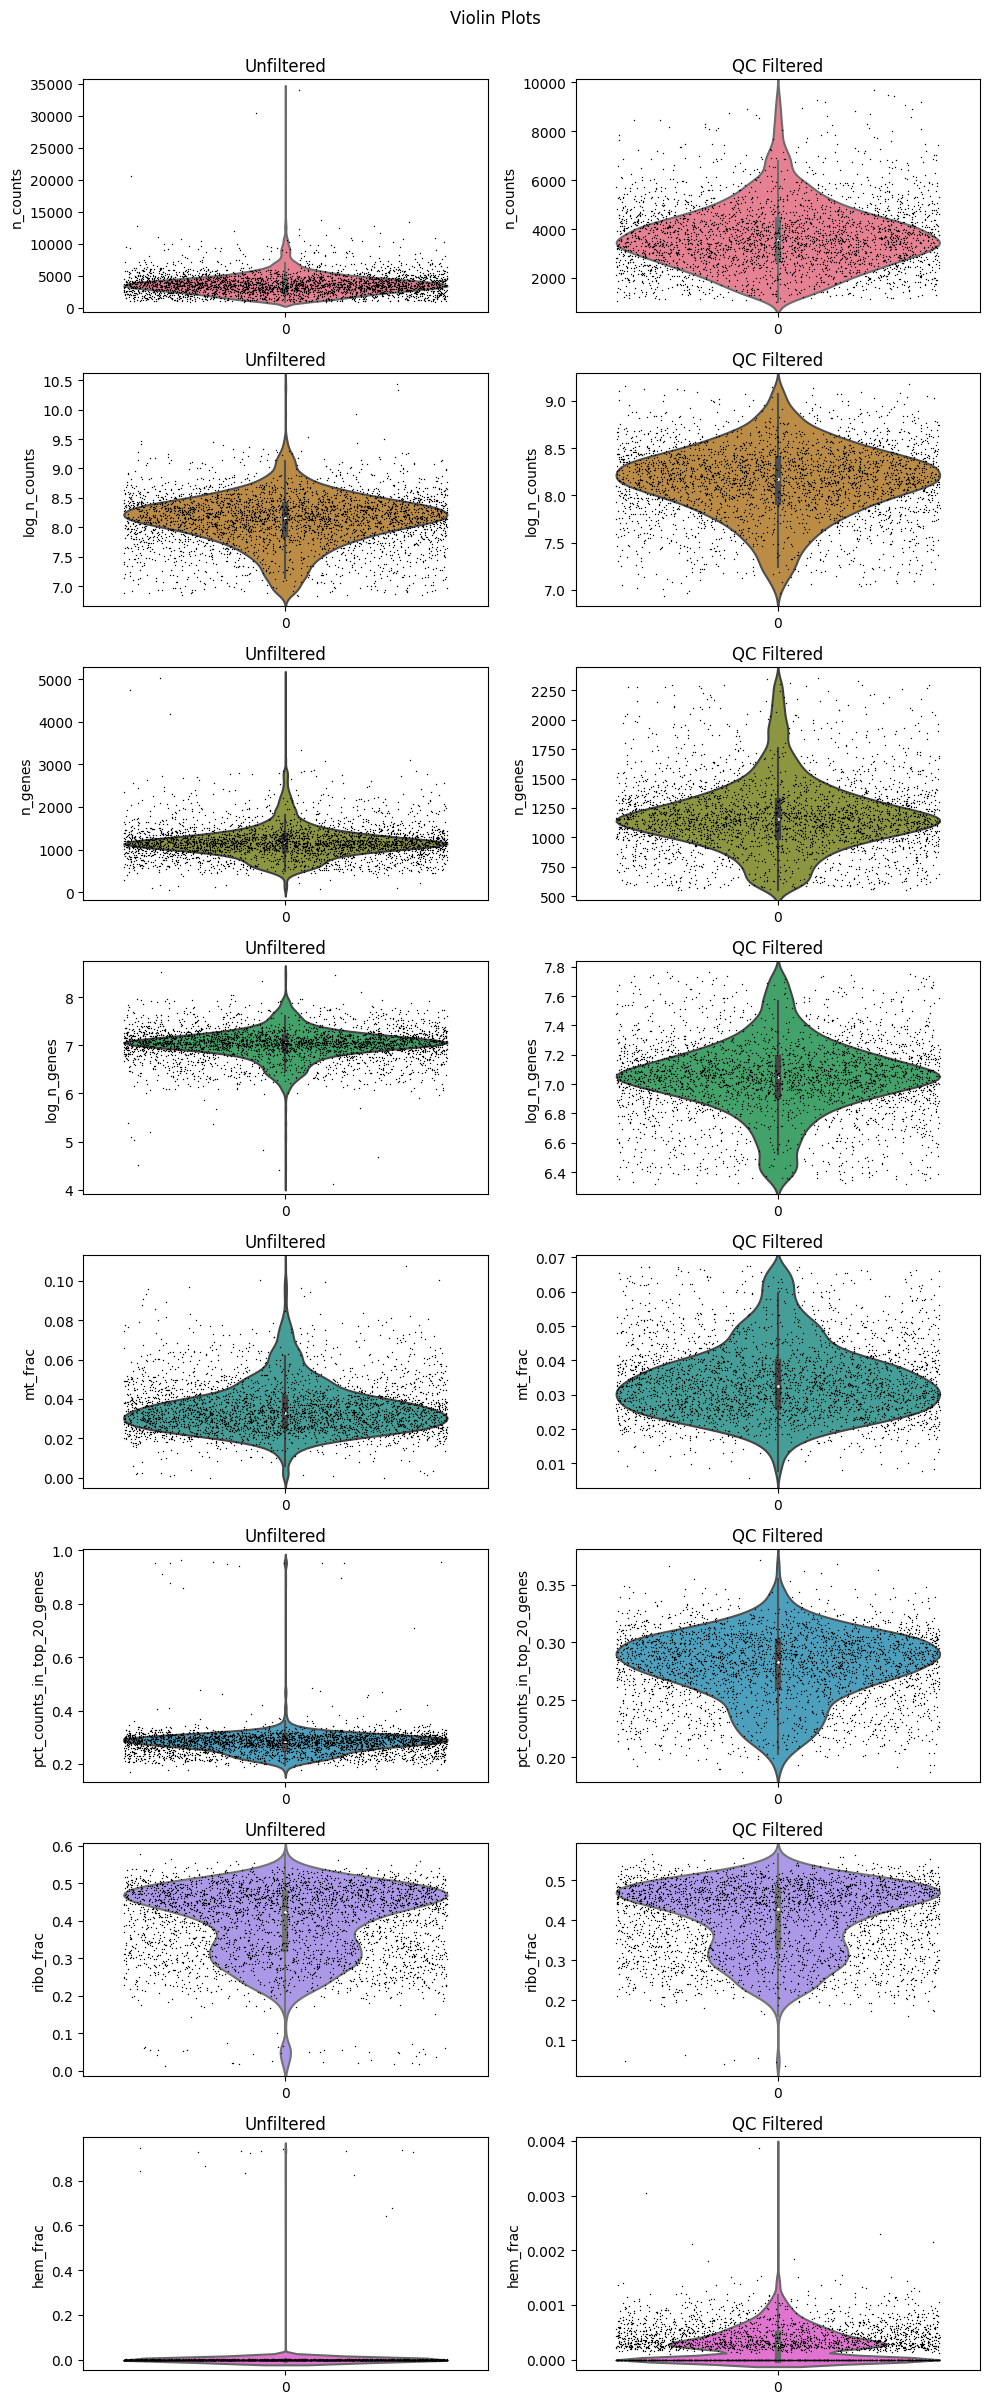

In [8]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes','ribo_frac','hem_frac'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

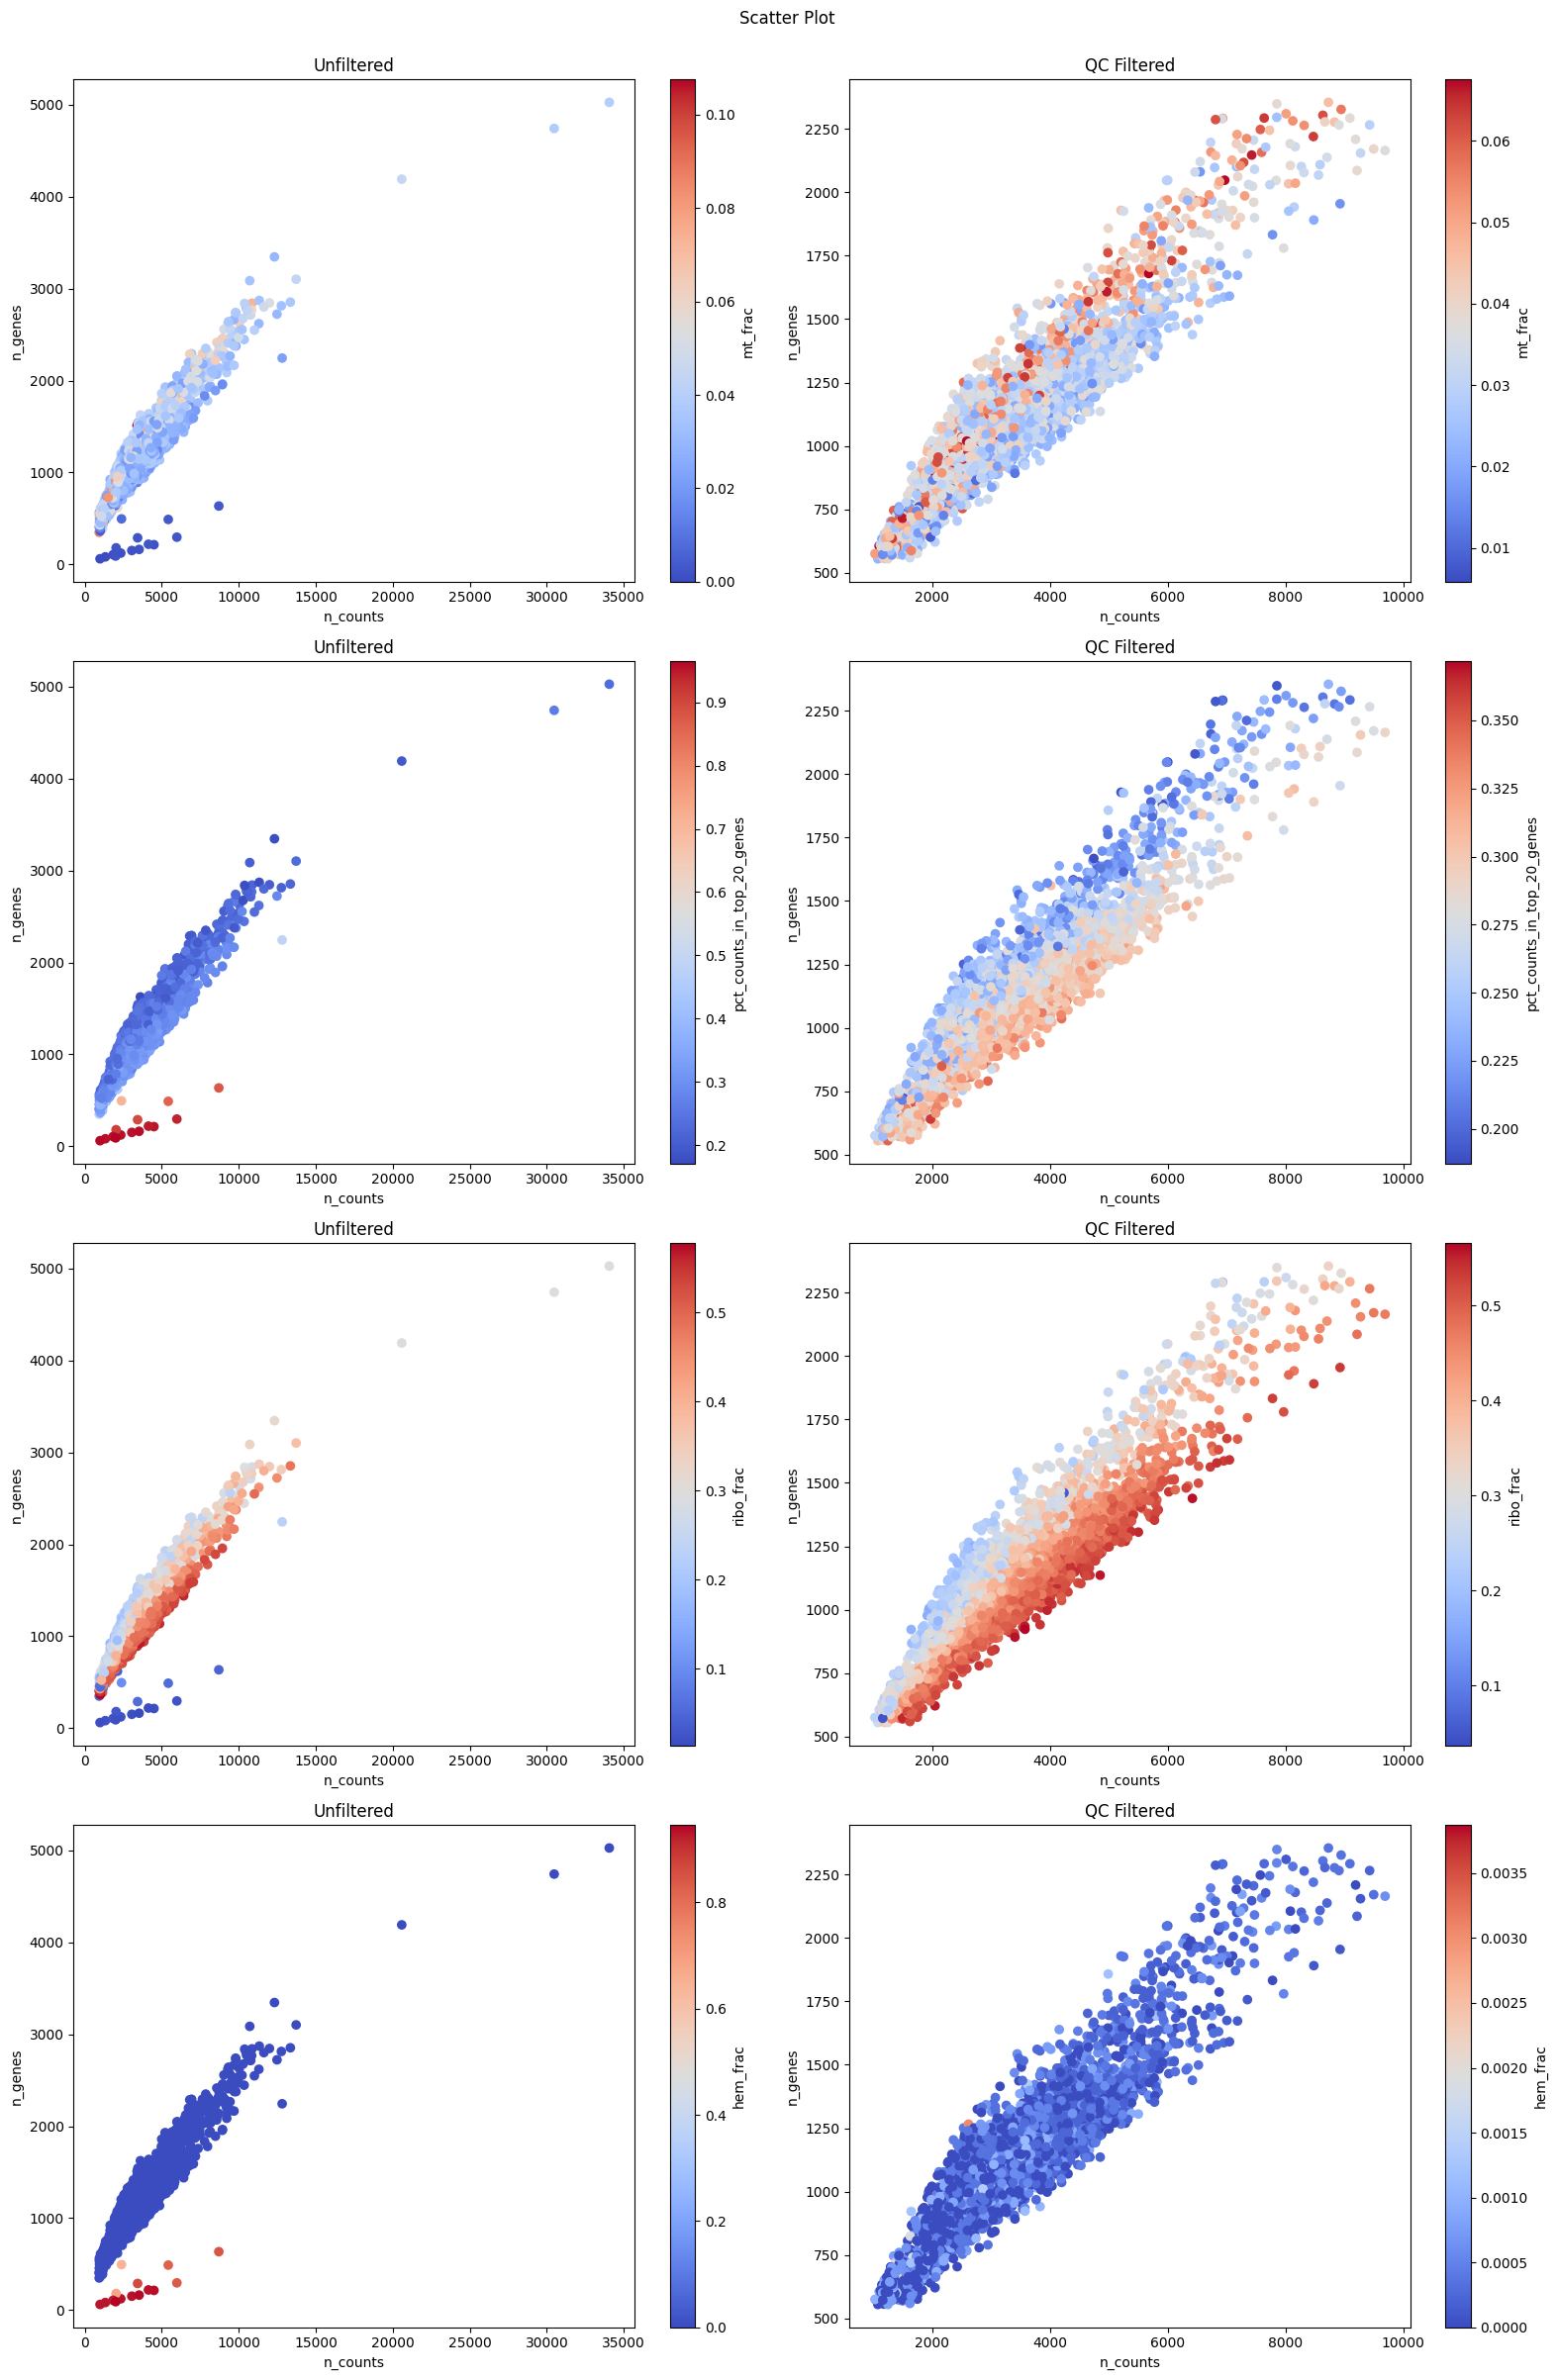

In [9]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [10]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [11]:
norm_qc_adata

AnnData object with n_obs × n_vars = 3131 × 12431
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'outlier', 'size_factors'
    var: 'gene_ids', 'n_cells'
    layers: 'pp_counts', 'log1p_counts'

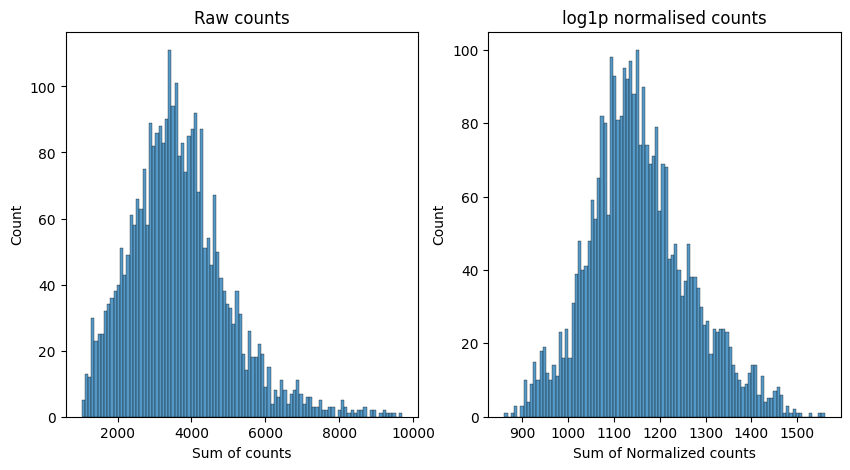

In [12]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [13]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("PBMCs_1.csv")
norm_qc_adata.write("PBMCs_1_adata.h5ad")